<a href="https://colab.research.google.com/github/Hitchiker-V/Kaggle-Ocean-LogBook-Weather-Predictions/blob/main/Ocean_Weather_Prediction_from_Log_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [21]:
!kaggle datasets download -d cwiloc/climate-data-from-ocean-ships

 27% 5.00M/18.5M [00:01<00:03, 3.71MB/s]
100% 18.5M/18.5M [00:01<00:00, 13.4MB/s]


In [22]:
!unzip climate-data-from-ocean-ships.zip

Archive:  climate-data-from-ocean-ships.zip
  inflating: CLIWOC15.csv            
  inflating: Geodata.csv             
  inflating: Lookup_ES_WindDirection.csv  
  inflating: Lookup_ES_WindForce.csv  
  inflating: Lookup_FR_WindDirection.csv  
  inflating: Lookup_FR_WindForce.csv  
  inflating: Lookup_NL_WindDirection.csv  
  inflating: Lookup_NL_WindForce.csv  
  inflating: Lookup_UK_WindDirection.csv  
  inflating: Lookup_UK_WindForce.csv  
  inflating: Magnetic_Declinations.csv  
  inflating: ShipLogbookID.csv       
  inflating: Weather.csv             


In [3]:
!pip install cartopy
import cartopy.crs as ccrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# !pip install cartopy
!pip install geopy
# import cartopy.crs as ccrs # Cartopy is a Python package designed to make drawing maps for data analysis and visualisation easy. crc : Coordinate Reference System
from geopy.geocoders import Nominatim

df = pd.read_csv('/content/CLIWOC15.csv', low_memory = False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:


# Looking at cols titles
df.head(1)

#Remove NaN entries -> VoyageIni as the common key
df1 = df.dropna(subset = ['Lon3', 'Lat3', 'UTC', 'VoyageIni'])
df2 = df.dropna(subset = ['VoyageFrom', 'VoyageTo', 'VoyageIni'])

# Let's plot a course for a given ship on a map -> grouping them according to starting date of trip
# Including ports of origin and destination as spheres, size propotional to number of visits

def plotPath(ship, df, ax, col='#444444', alp=0.5): # alpha for transparency
  path = df[df['ShipName'] == ship][['Lon3', 'Lat3', 'UTC', 'VoyageIni']]

  # Grouping path according to starting date of Voyage -> To split the voyages that "jumps" from one part to another of the globe

  groupedPath = path.groupby('VoyageIni')
  for name, group in groupedPath:
    if group.size < 2:
      continue
    group.sort_values(by='UTC', inplace = True)

    # Drawing a path in the background
    x,y = group['Lon3'].toList(), group['Lat3'].toList()
    ax.plot(x, y, color = col, alpha = alp, transform = ccrs.Geodetic(), linewidth=0.5)

def plotPorts(ship, df, ax, col1='#444444', col2 = '#444444'):
  dictFrom, dictTo = {}, {}
  path = df[df['ShipName'] == ship][['VoyageFrom', 'VoyageTo', 'VoyageIni']]
  # Starting port
  groupedFrom = path.groupby('VoyageFrom')
  groupedTo = path.groupby('VoyageTo')

  for name, group in groupedFrom:
    place = group['VoyagedFrom'].iloc[0]
    # starting port -> checking if origin port from it's name
    if place not in dictFrom:
      location = geolocator.geocode(place)
      if location is not None:
        dictFrom[place] = [group.VoyageIni.nunique(), location.longitude, location.latitude]
      else:
        dictFrom[place][0] = dictFrom[place][0] + group.VoyageIni.nunique()
      for name, group in groupedTo:
        place = group['VoyageTo'].iloc[0]
        if place not in dictTo:
          location = geolocator.geocode(place)
          if location is not None:
            dictTo[place] = [group.VoyageIni.nunique(), location.longitude, location.latitude]
          else:
            dictFrom[place][0] = dictFrom[place][0] + group.VoyageIni.nunique()

    # Generating a plot with ports with circles
    sumF = sum([v[0] for k, v in dictFrom.items()])
    sumT = sum([v[0] for k, v in dictTo.items()])
    maxA = max([v[0] for k, v in dictFrom.items()] + [v[0] for k, v in dictTo.items()])

    for el in dictFrom[:10]:
      ax.plot(dictFrom[el][1], dictFrom[el][2], color = col1, transform = ccrs.Geodetic(), marker = 'o', ms = dictFrom[el][0]*20/maxA, mec='#222222', mew = 0.5)

    for el in dictTo[:10]:
      ax.plot(dictTo[el][1], dictTo[el][2], color = col2, transform = ccrs.Geodetic(), marker = 'o', ms = dictTo[el][0]*20/maxA, mec='#222222', mew = 0.5)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


AttributeError: ignored

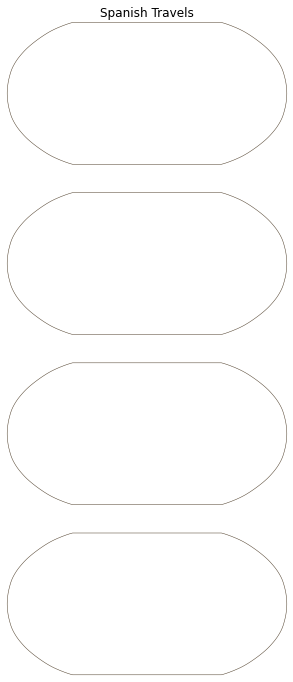

In [10]:
# initializing geolocator
geolocator = Nominatim()

ships = df1[df1['Nationality'] == 'Spanish']['ShipName'].unique()

fig = plt.figure(figsize=(8,12))
gs1 = gridspec.GridSpec(4,1)
ax1, ax2, ax3, ax4 = fig.add_subplot(gs1[0], projection = ccrs.Robinson()), \
                fig.add_subplot(gs1[1], projection = ccrs.Robinson()), \
                fig.add_subplot(gs1[2], projection = ccrs.Robinson()), \
                fig.add_subplot(gs1[3], projection = ccrs.Robinson())

# shapes=[[[141.0, -2.6], [146.97, -6.72], [150.8, -10.29], [146.05, -8.07], [140.14, -8.3], [135.99, -4.55], [133.07, -2.46], [132.38, -0.37], [139.18, -2.05]], [[114.2, 4.53], [118.35, 5.71], [117.88, 1.83], [116.0, -3.66], [110.22, -2.93], [111.17, 1.85]], [[-88.15, 74.39], [-96.75, 77.16], [-87.84, 75.57], [-81.95, 74.44]], [[-82.27, 23.19], [-76.52, 21.21], [-75.63, 19.87], [-79.28, 21.56], [-83.91, 22.15], [-82.51, 23.08]], [[-55.6, 51.32], [-53.48, 49.25], [-53.96, 47.63], [-59.42, 47.9], [-55.6, 51.32]], [[-83.88, 65.11], [-83.11, 64.1], [-85.16, 65.66]], [[-78.77, 72.35], [-67.91, 70.12], [-63.92, 65.0], [-64.67, 63.39], [-71.02, 62.91], [-77.9, 65.31], [-74.84, 68.55], [-84.94, 69.97], [-88.41, 73.54], [-78.77, 72.35]], [[-107.82, 75.85], [-113.87, 74.72], [-109.07, 75.47]], [[-121.54, 74.45], [-120.46, 71.38], [-121.54, 74.45]], [[49.54, -12.47], [49.67, -15.71], [47.55, -23.78], [43.35, -22.78], [44.04, -18.33], [46.88, -15.21], [49.54, -12.47]], [[-48.66, -78.05], [-44.88, -80.34], [-50.99, -79.61]], [[-73.92, -71.27], [-69.72, -69.25], [-69.96, -72.31], [-73.92, -71.27]], [[151.3, -5.84], [149.85, -5.51], [152.14, -4.15]], [[176.89, -40.07], [173.82, -39.51], [173.05, -35.24], [175.81, -36.8], [177.21, -39.15]], [[169.67, -43.56], [173.25, -41.33], [172.31, -43.87], [166.68, -46.22]], [[147.69, -40.81], [146.05, -43.55], [147.69, -40.81]], [[126.15, -32.22], [120.58, -33.93], [115.56, -34.39], [115.16, -30.6], [113.34, -26.12], [113.39, -24.38], [115.46, -21.5], [119.25, -19.95], [123.01, -16.41], [125.17, -14.68], [128.36, -14.87], [131.22, -12.18], [134.39, -12.04], [136.31, -13.29], [137.58, -16.22], [141.27, -16.39], [141.69, -12.41], [143.16, -12.33], [145.27, -15.43], [148.18, -19.96], [150.9, -23.46], [153.51, -29.0], [151.01, -34.31], [147.38, -38.22], [142.75, -38.54], [138.12, -35.61], [137.81, -32.9], [134.27, -32.62]], [[122.93, 0.88], [120.18, 0.24], [121.51, -1.9], [121.74, -4.85], [119.8, -5.67], [119.83, 0.15]], [[108.49, -6.42], [114.56, -8.75], [106.45, -7.35]], [[104.37, -1.08], [103.87, -5.04], [98.6, 1.82], [98.37, 4.27], [103.44, -0.71]], [[126.38, 8.41], [124.22, 6.16], [122.31, 8.03], [126.22, 9.29]], [[141.88, 39.18], [135.79, 33.46], [130.69, 31.03], [132.62, 35.43], [139.88, 40.56]], [[-4.21, 58.55], [-1.11, 54.62], [0.55, 50.77], [-4.31, 51.21], [-2.95, 53.98], [-6.15, 56.79]], [[-14.51, 66.46], [-21.78, 64.4], [-19.06, 66.28]], [[142.91, 53.7], [143.51, 46.14], [141.59, 51.94]], [[122.34, 18.22], [122.7, 14.34], [122.03, 13.78], [119.92, 15.41], [122.34, 18.22]], [[-77.35, 8.67], [-74.2, 11.31], [-71.36, 11.54], [-71.35, 10.21], [-68.19, 10.55], [-61.88, 10.72], [-59.1, 8.0], [-55.03, 6.03], [-50.51, 1.9], [-46.57, -0.94], [-37.22, -4.82], [-37.05, -11.04], [-39.58, -18.26], [-45.35, -23.8], [-49.59, -29.22], [-55.67, -34.75], [-56.74, -36.41], [-62.15, -40.68], [-63.46, -42.56], [-66.6, -47.03], [-68.15, -52.35], [-73.7, -52.84]], [[-77.88, 7.22], [-77.93, 2.7], [-80.02, 0.36], [-79.77, -2.66], [-79.45, -7.93], [-73.44, -16.36], [-70.91, -27.64], [-73.59, -37.16], [-72.72, -42.38], [-75.48, -50.38]], [[-74.66, -52.84], [-68.25, -53.1], [-68.15, -55.61]], [[53.51, 73.75], [68.85, 76.54], [57.54, 70.72], [54.43, 73.63]], [[15.14, 79.67], [17.12, 76.81], [13.72, 79.66]], [[-77.88, 7.22], [-79.76, 8.58], [-81.06, 7.82], [-82.85, 8.07], [-84.65, 9.62], [-85.79, 10.44], [-87.17, 12.46], [-87.9, 13.15], [-91.69, 14.13], [-97.26, 15.92], [-103.5, 18.29], [-105.27, 21.42], [-109.44, 25.82], [-112.27, 29.27], [-114.77, 30.91], [-112.76, 27.78], [-110.17, 24.27], [-111.67, 24.48], [-114.47, 27.14], [-115.89, 30.18], [-119.08, 34.08], [-122.95, 38.11], [-124.02, 44.62], [-122.34, 47.36], [-127.85, 52.33], [-133.54, 57.18], [-143.96, 60.0], [-151.72, 59.16], [-153.29, 58.86], [-160.29, 55.64], [-161.8, 55.89], [-158.19, 58.62], [-162.05, 59.27], [-165.73, 62.07], [-160.96, 64.22], [-166.43, 64.69], [-162.49, 66.74], [-162.93, 69.86], [-153.9, 70.89], [-143.59, 70.15], [-132.93, 69.51], [-124.42, 70.16], [-115.25, 68.91], [-108.81, 68.31], [-99.9, 67.81], [-94.23, 69.07], [-92.41, 69.7], [-85.58, 68.78], [-81.39, 67.11], [-89.91, 64.03], [-93.22, 58.78], [-85.01, 55.3], [-78.6, 52.56], [-78.52, 58.8], [-72.91, 62.11], [-66.2, 58.77], [-59.57, 55.2], [-57.13, 51.42], [-68.51, 49.07], [-65.12, 48.07], [-61.04, 45.27], [-67.14, 45.14], [-70.49, 41.8], [-72.29, 41.27], [-74.26, 40.47], [-75.07, 38.78], [-76.54, 38.72], [-76.36, 34.81], [-81.34, 31.44], [-80.13, 25.82], [-82.86, 27.89], [-86.4, 30.4], [-89.41, 29.16], [-94.69, 29.48], [-97.53, 24.99], [-96.29, 19.32], [-90.77, 19.28], [-86.81, 21.33], [-88.3, 18.5], [-88.36, 16.53], [-87.9, 15.86], [-85.68, 15.95], [-83.41, 15.27], [-83.5, 12.87], [-83.59, 10.79]], [[-71.71, 19.71], [-69.25, 19.02], [-70.52, 18.18], [-73.45, 18.22], [-72.78, 19.48]], [[-16.26, 19.1], [-16.26, 22.68], [-13.77, 26.62], [-9.43, 32.04], [-4.59, 35.33], [3.16, 36.78], [10.21, 37.23], [10.15, 34.33], [15.25, 32.27], [20.13, 32.24], [25.16, 31.57], [31.69, 31.43], [34.75, 32.07], [36.15, 35.82], [30.62, 36.68], [26.17, 39.46], [36.91, 41.34], [40.32, 43.13], [39.15, 47.04], [35.51, 45.41], [32.63, 45.52], [29.63, 45.04], [28.99, 41.3], [24.93, 40.95], [23.35, 39.19], [23.15, 36.42], [19.98, 39.69], [18.88, 42.28], [14.9, 45.08], [12.33, 45.38], [16.17, 41.74], [16.87, 40.44], [15.89, 38.75], [12.89, 41.25], [7.85, 43.77], [0.81, 41.01], [-2.15, 36.67], [-7.45, 37.1], [-9.45, 39.39], [-9.39, 43.03], [-1.19, 46.01], [-0.99, 49.35], [6.91, 53.48], [8.09, 56.54], [10.37, 56.61], [10.94, 54.01], [18.62, 54.68], [22.52, 57.75], [24.6, 59.47], [22.87, 59.85], [25.4, 65.11], [17.12, 61.34], [14.1, 55.41], [5.67, 58.59], [16.44, 68.56], [30.01, 70.19], [40.02, 66.27], [37.01, 63.85], [43.02, 66.42], [45.56, 67.57], [54.75, 68.09], [63.5, 69.55], [66.72, 70.71], [72.47, 71.09], [73.92, 66.79], [73.1, 71.45], [77.58, 72.27], [86.01, 74.46], [98.92, 76.45], [107.24, 76.48], [109.4, 74.18], [119.02, 73.12], [129.72, 71.19], [139.15, 72.42], [159.71, 69.72], [170.01, 69.65]], [[180.0, 64.98], [177.36, 62.52], [165.84, 60.16], [162.13, 56.12], [156.42, 51.7], [161.87, 60.34], [154.22, 59.76], [142.2, 59.04], [141.35, 53.09], [135.52, 43.99], [129.97, 41.94], [127.5, 39.32], [128.19, 34.89], [125.69, 37.94], [125.13, 38.85], [121.59, 39.36], [117.53, 38.74], [122.52, 36.93], [121.91, 31.69], [120.4, 27.05], [113.24, 22.05], [108.52, 21.72], [108.88, 15.28], [105.08, 9.92], [100.1, 13.41], [101.02, 6.86], [103.43, 3.38], [101.27, 3.27], [98.99, 7.91], [98.43, 12.03], [94.81, 15.8], [92.08, 21.19], [89.7, 21.86], [85.06, 19.48], [80.03, 15.14], [78.28, 8.93], [74.62, 13.99], [70.47, 20.88], [64.53, 25.24], [55.72, 26.96], [48.94, 30.32], [49.47, 27.11], [50.74, 25.48], [51.79, 24.02], [56.49, 26.31], [59.18, 22.99], [58.03, 20.48], [56.28, 17.88], [52.39, 16.38], [47.35, 13.59], [44.18, 12.59], [42.7, 15.72], [40.94, 19.49], [37.48, 24.29], [34.63, 28.06], [33.92, 27.65], [34.47, 25.6], [36.97, 20.84], [41.18, 14.49], [43.15, 11.46], [48.02, 11.19], [51.13, 11.75], [47.74, 4.22], [40.88, -2.08], [38.8, -6.48], [40.32, -10.32], [39.45, -16.72], [35.18, -21.25], [35.04, -24.48], [32.46, -28.3], [28.22, -32.77], [22.99, -33.92], [18.42, -34.0], [17.06, -29.88], [14.39, -22.66], [11.64, -16.67], [13.74, -11.3], [12.73, -6.93], [8.8, -1.11], [9.4, 3.73], [5.9, 4.26], [-0.51, 5.34], [-6.53, 4.71], [-11.71, 6.86], [-14.58, 10.21], [-16.61, 12.17], [-16.46, 16.14]], [[-180.0, -84.71], [-172.89, -84.06], [-155.19, -85.1], [-150.9, -83.9], [-156.84, -81.1], [-148.06, -79.65], [-158.37, -76.89], [-148.75, -76.91], [-142.79, -75.34], [-133.75, -74.44], [-122.56, -74.5], [-113.3, -74.03], [-104.88, -74.95], [-103.11, -73.73], [-97.69, -73.56], [-88.42, -73.01], [-80.3, -73.13], [-71.62, -73.26], [-67.92, -70.85], [-67.62, -67.72], [-63.63, -64.9], [-57.81, -63.27], [-62.02, -64.8], [-64.88, -67.15], [-62.57, -69.99], [-60.83, -73.7], [-68.45, -76.01], [-75.4, -77.28], [-76.85, -79.51], [-63.26, -81.75], [-51.54, -82.0], [-36.27, -81.12], [-31.62, -79.3], [-31.0, -77.36], [-21.22, -75.91], [-16.11, -73.46], [-9.1, -71.32], [-3.05, -71.29], [5.16, -70.62], [11.95, -70.64], [19.26, -69.89], [27.09, -70.46], [33.87, -68.5], [40.02, -69.11], [47.44, -67.72], [53.61, -65.9], [59.94, -67.41], [66.91, -67.86], [67.95, -70.7], [71.57, -71.7], [76.63, -69.62], [82.05, -67.37], [88.36, -66.48], [95.02, -67.17], [101.58, -66.31], [109.16, -66.84], [115.6, -66.7], [123.22, -66.48], [130.78, -66.43], [135.87, -66.03], [143.06, -66.8], [150.13, -68.56], [158.03, -69.48], [166.11, -70.76], [170.11, -72.89], [164.23, -75.46], [166.6, -78.32], [159.79, -80.95], [169.4, -83.83]], [[-180.0, 68.96], [-170.89, 65.54], [-177.22, 65.52]], [[-155.4, 20.08], [-155.94, 19.06], [-155.4, 20.08]], [[46.68, 44.61], [53.22, 46.23], [51.34, 43.13], [54.01, 41.55], [53.74, 37.91], [48.86, 38.82], [48.58, 41.81]], [[-106.52, 73.08], [-102.09, 69.12], [-113.85, 69.01], [-114.35, 70.6], [-117.87, 72.71], [-108.19, 71.65]], [[-96.02, 80.6], [-85.81, 79.34], [-94.97, 79.37]], [[-91.59, 81.89], [-81.1, 83.02], [-63.68, 82.9], [-69.47, 80.62], [-76.34, 78.18], [-83.17, 76.45], [-84.98, 77.54], [-84.2, 80.21], [-91.59, 81.89]], [[-46.76, 82.63], [-26.52, 82.3], [-20.62, 81.52], [-18.9, 79.4], [-20.67, 75.16], [-22.3, 72.18], [-25.54, 71.43], [-31.78, 68.12], [-40.68, 64.14], [-48.26, 60.86], [-53.97, 67.19], [-54.68, 69.61], [-55.83, 71.65], [-63.39, 76.18], [-73.3, 78.04], [-62.23, 81.32], [-46.6, 81.99]]]


# def addCoast(ax,shapes=shapes,col='#3e2c16',alp=0.5):
#        for el in shapes:
#             if len(el)>=4:
#                x,y=[pt[0] for pt in el], [pt[1] for pt in el]
#                ax.plot(x,y,color=col,alpha=alp,transform=ccrs.Geodetic(),linewidth=0.5)

def ax_init(ax):
    ax.set_global()
    #the following commands require Cartopy to contact the server and download some information
    #like the coastlines shape, but unfortunately it doesn't seem to be working at the moment, 
    #so I deactivated them, we'll need a bit of fantasy to see the shape of the landmasses 
    #but that's ok, if you download the code locally it should work fine
    #ax.stock_img()
    ##ax.add_feature(cartopy.feature.LAND, facecolor='#dbc79c', alpha=0.5)
    #ax.add_feature(cartopy.feature.OCEAN, facecolor='#dbc79c', alpha=0.5)
    #ax.coastlines(color='#3e2c16', linewidth=0.5, alpha=0.5)
    #we will use here the quick&dirty alternative
    # addCoast(ax)  
    ax.outline_patch.set_edgecolor('#51412D')
    ax.outline_patch.set_linewidth(0.5)
    ax.outline_patch.set_alpha(1)   

    
ax_init(ax1), ax_init(ax2), ax_init(ax3), ax_init(ax4)

ax1.set_title("Spanish Travels")
#ships = df1[df1['Nationality']!='Spanish']['ShipName'].unique()
#for ship in ships[:]:
#	plotPath(ship,df1,ax1,'#444444',0.1)

ships = df1[df1['Nationality']=='Spanish']['ShipName'].unique()
for ship in ships[:]:
    plotPath(ship,df1,ax1,'#BB3333',0.3)
# groupedPath.head()